Some really important links this notebook works on:

1. YOLO basics: https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/
2. Implementing albumentations with tf.keras's Sequence: https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac
3. Majority of content was inspired from this awesome Kernel: https://www.kaggle.com/mattbast/object-detection-tensorflow-end-to-end

## Import the neccessary modules:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as albu
from tqdm import tqdm
from PIL import Image, ImageDraw

import os

plt.style.use("dark_background")
%matplotlib inline

### Load the neccessary files

In [ ]:
! ls ../input/global-wheat-detection/

In [ ]:
main_dir = "../input/global-wheat-detection/"

train_files = tf.io.gfile.glob(main_dir + "train/*")
test_files = tf.io.gfile.glob(main_dir + "test/*")

print ("No of Train files: {}\nNo of Test files: {}".format(len(train_files), len(test_files)))

In [ ]:
sample_sub = pd.read_csv(main_dir + "sample_submission.csv")
train = pd.read_csv(main_dir + "train.csv")

train.shape, sample_sub.shape

### EDA:

In [ ]:
# how does the sub file look like?
sample_sub.head()

It takes the following format: 

    img_id | confidence x y w h

A short desc on possible bounding box label representations. Note that our data is stored and expected to be of the **Coco Format**:

<img src=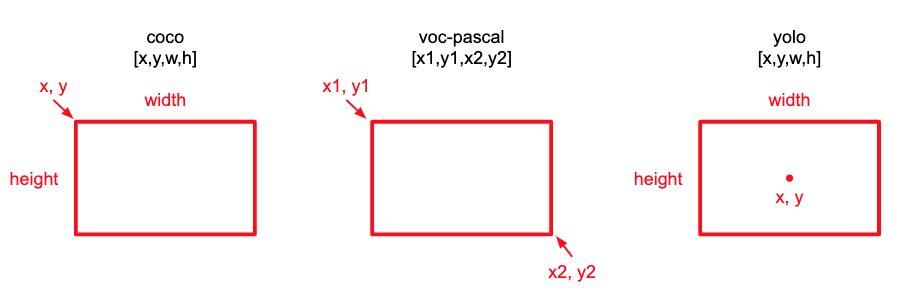>

In [ ]:
train.head()

In [ ]:
# how many unique values does each col contain?
print ("Tot rows:", train.shape[0])
train.nunique()

In [ ]:
train.width.unique(), train.height.unique()

Height and width have the same value and are redundant. Let's drop them.

In [ ]:
train.drop(['width', 'height'], axis=1, inplace=True)

In [ ]:
temp = train.source.value_counts()
ax = temp.plot(kind='bar', figsize=(15, 5), title='Source: Count plots')
for i, value in enumerate(temp):
    ax.text(i-0.1, value, value);

'''
You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.
'''

In [ ]:
# An image can obviously come only from one source
(train.groupby("image_id")['source'].nunique() != 1).any()

In [ ]:
train.info()

In [ ]:
# bbox is stored as strings, let process them to list values
train['bbox'] = train['bbox'].transform(lambda x: list(map(float, x.strip("[]").split(", "))))

In [ ]:
labels = train.groupby("image_id")['bbox'].apply(np.stack)
len(labels)

In [ ]:
# how many bbox on avg per image?
temp = labels.apply(len)
temp.describe()

In [ ]:
train.head()

In [ ]:
# avg bounding box based on source
temp = train.groupby(["source", "image_id"]).count().reset_index()
temp.groupby("source")["bbox"].agg(["count", "min", "mean", "max", "std"])

In [ ]:
f, ax = plt.subplots(nrows=7, figsize=(20, 15))
for i, source in enumerate(sorted(train.source.unique())):
    temp.query(f"source == '{source}'")['bbox'].plot(kind='hist', ax=ax[i], title=source)
    
f.suptitle("Visualizing BBox Distributions for various sources")
f.tight_layout(rect=[0, 0.03, 1, 0.95]);

### Let's plot Em images!
Lets write a simple utility function that when given an image_id & bbox, returns an image with bboxes drawn over it: 

In [ ]:
def draw_bboxes(img_inp, bboxes, source='train', W=8, img_id_as_input=True, color='red'):
    '''Curtesy of : Mattbast
    From: https://www.kaggle.com/mattbast/object-detection-tensorflow-end-to-end'''
    
    def draw_bbox(draw, bbox):
        x, y, width, height = bbox
        draw.rectangle([x, y, x+width, y+height], width=W, outline=color)
        
    if img_id_as_input:
        image = Image.open(f"{main_dir}{source}/{img_inp}.jpg")
    else:
        image = Image.fromarray(img_inp)
        
    draw = ImageDraw.Draw(image)
    
    for bbox in bboxes:
        draw_bbox(draw, bbox)
        
    return np.array(image)

Plotting those images with very little bboxes and those with a lot of bboxes:

In [ ]:
f, ax = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
ax = ax.ravel()

for i, (_, img_id, count) in enumerate(temp[["image_id", "bbox"]][temp.bbox < 3].sort_values(by='bbox').itertuples()):
    ax[i].imshow(draw_bboxes(img_id, labels[img_id]))
    ax[i].set_title("Bbox count: " + str(count))
    ax[i].axis('off')  
    
f.suptitle("Tiny No. of bboxes!");

f, ax = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i, (_, img_id, count) in enumerate(temp[["image_id", "bbox"]][temp.bbox > 100].sort_values(by='bbox').itertuples()):
    
    ax[0][i].imshow(plt.imread(f"{main_dir}train/{img_id}.jpg"))
    ax[0][i].axis('off')
    ax[0][i].set_title(f"{img_id} without BBox")
    
    ax[1][i].imshow(draw_bboxes(img_id, labels[img_id]))
    ax[1][i].set_title("Bbox Count: " + str(count))
    ax[1][i].axis('off')  
    
f.suptitle("Large No. of bboxes!");

Plot the images not found in CSV. Does any exist?

In [ ]:
# those images in csv but not actually present. No such image exits
len(np.setdiff1d(labels.index.values, list(map(lambda x: x.split("/")[-1].split(".")[0], train_files))))

In [ ]:
# those images not in train.csv but in train images
missing_ids = np.setdiff1d(list(map(lambda x: x.split("/")[-1].split(".")[0], train_files)), labels.index.values)

f, ax = plt.subplots(ncols=5, nrows=5, figsize=(20, 20))
ax = ax.ravel()
for i, img_id in enumerate(np.random.choice(missing_ids, (25,))):
    ax[i].imshow(plt.imread(f"{main_dir}train/{img_id}.jpg"))
    ax[i].set_title(img_id)
    ax[i].axis('off')

#### Plotting the images from different categories:

In [ ]:
# plotting without bboxes
f, ax = plt.subplots(nrows=5, ncols=7, figsize=(20, 15))
for i, (source, img_ids) in enumerate(train.groupby("source")['image_id'].apply(lambda x: list(x.sample(5))).iteritems()):
    for j, img_id in enumerate(img_ids):
        ax[j][i].imshow(plt.imread(f"{main_dir}train/{img_id}.jpg"))
        ax[j][i].set_title(source)
        ax[j][i].axis('off')

In [ ]:
# with and Without Bounding boxes
f, ax = plt.subplots(nrows=2, ncols=7, figsize=(20, 8))
temp = train.groupby("source")['image_id'].apply(lambda x: x.sample(1)).reset_index(level=0)

for i, (_, source, img_id) in enumerate(temp.itertuples()):
    ax[0][i].imshow(plt.imread(f"{main_dir}train/{img_id}.jpg"))
    ax[0][i].set(title=source +" Without Bboxes")
    ax[0][i].axis('off')
    
    ax[1][i].imshow(draw_bboxes(img_id, labels[img_id]))
    ax[1][i].set(title=source +" With Bboxes")
    ax[1][i].axis('off')
    
f.tight_layout();

#### Plotting the test images:

In [ ]:
# how does the test images look like?
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
ax = ax.ravel()

for i, img_loc in enumerate(test_files):
    ax[i].imshow(plt.imread(img_loc))
    ax[i].axis('off')
    ax[i].set_title(img_loc.split("/")[-1].split(".")[0])

Let's remove those bounding boxes which have very small height or width:

In [ ]:
# How many such exists?
removed_bboxes = []
cleaned_labels = {}

for img_id, bboxes in labels.iteritems():
    for bbox in bboxes:
        if bbox[2] < 10 or bbox[3] < 10:
            removed_bboxes.append((img_id, bbox))
        else:
            cleaned_labels[img_id] = cleaned_labels.get(img_id, []) + [bbox]
            
labels = pd.Series(map(np.stack, cleaned_labels.values()), index=cleaned_labels.keys()).rename_axis("image_id")
del cleaned_labels

"No of bboxes removed: {}".format(len(removed_bboxes))

Do a simple Train / Val split:

In [ ]:
train_img_ids = labels.iloc[:int(0.95 * len(labels))].index
val_img_ids = np.setdiff1d(labels.index, train_img_ids)

len(train_img_ids), len(val_img_ids)

How does the image look like with 32 grids?

In [ ]:
GRID_SIZE = 32

plt.figure(figsize=(15, 15))
temp = labels.map(len).argmax()
plt.imshow(draw_bboxes(labels.index[temp], labels.iloc[temp]))

bboxes = labels.iloc[temp].copy()
bboxes[:, 0] = bboxes[:, 0] + (bboxes[:, 2] / 2)
bboxes[:, 1] = bboxes[:, 1] + (bboxes[:, 3] / 2)

plt.scatter(*list(zip(*bboxes[:, :2])), c='b')

plt.vlines(range(0, 1024, 1024//GRID_SIZE), 0, 1024, color='y')
plt.hlines(range(0, 1024, 1024//GRID_SIZE), 0, 1024, color='y')
plt.title("Image with Max Bounding boxes")
plt.axis('off');

The image looks pretty clustered. 5 anchors will do us good with grid_size of 32!

In [ ]:
IMG_SHAPE = (256, 256)
FACTOR = 1024 / IMG_SHAPE[0]
GRID_SIZE = 32
ANCHORS = 5
BATCH_SIZE = 16

Lets perform some data augmentations to our dataset using the albumentation library:

Again from <a href=https://www.kaggle.com/mattbast/object-detection-tensorflow-end-to-end>this</a> Notebook: 

''' 
- random sized crop: The model needs to be able to detect a wheat head regardless of how close or far away the head is to the camera. To produce more zoom levels in the dataset the crop method will take a portion of the image and zoom in to create a new image with larger wheat heads.

- flip amd rotate: The wheat heads can point in any direction. To create more examples of wheat heads pointing in different directions the image will randomly be flipped both horizontally and vertically or rotated.

- hue saturation and brightness: these are various methods that will alter the lighting of the image which will help to create different lighting scenarios. This helps as the test pictures are from various countries each with their own lighting levels.

- noise: Some wheat heads aren't quite in focus. Adding some noise to the images helps to catch these wheat heads while also forcing the model to learn more abstract wheat head shapes. This helps a lot with over-fitting.

- cutout: randomly remove small squares of pixels in the image. This prevents the model simply memorizing certain wheat heads and instead forces it to learn the patterns that represent a wheat head.

- clahe: this is a must have. In many images the wheat heads are a similar colour to the grass in the background making it tricky for the model to differentiate between them. CLAHE helps to exemplify the colour difference between the two.

- grayscale: I found that there were a few images with a yellow/gold tint. My model was learning to detect wheat heads without a tint (as most images do not contain a tint) and was really struggling to detect anything on the yellow images. By converting all images to grey scale the model is forced to ignore these tints making it much more effective at identifying wheat heads regardless of tint.

'''

Let's create augmentation Pipeline for processing our images:

In [ ]:
TRAIN_AUG = albu.Compose([
    albu.RandomSizedCrop(
            min_max_height=[int(IMG_SHAPE[0] * 0.85)] * 2, 
            height=IMG_SHAPE[0], 
            width=IMG_SHAPE[1], 
            p=0.8
        ),
    
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
    
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
    
        albu.OneOf([
                albu.GaussNoise(),
                albu.GlassBlur(),
                albu.ISONoise(),
                albu.MultiplicativeNoise(),
            ], p=0.5),
    
        albu.Cutout(
            num_holes=8, 
            max_h_size=8, 
            max_w_size=8, 
            fill_value=0, 
            p=0.5
        ),
    
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
        bbox_params={'format': 'coco', 'label_fields': ['labels']}
)

VAL_AUG = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1)
])

Demo augmentation:

In [ ]:
org = plt.imread(f"{main_dir}train/{img_id}.jpg")
org = tf.cast(tf.image.resize(org, IMG_SHAPE), tf.uint8).numpy()
org_bboxes = labels[img_id] / FACTOR
aug = TRAIN_AUG(image=org, bboxes=org_bboxes, labels=np.ones(len(org_bboxes)))

aug.keys()

Let's visualize how are augmentation pipeline works:

In [ ]:
f, ax = plt.subplots(figsize=(20, 20), ncols=3, nrows=3)
ax = ax.ravel()

ax[0].imshow(draw_bboxes(org, org_bboxes, img_id_as_input=False, W=2))
ax[0].set_title("Original Image")
ax[0].axis('off')

for i in range(8):
    aug = TRAIN_AUG(image=org, bboxes=org_bboxes, labels=np.ones(len(org_bboxes)))
    ax[i + 1].imshow(draw_bboxes(aug['image'], aug['bboxes'], img_id_as_input=False, W=2))
    ax[i + 1].axis("off")
    ax[i + 1].set_title(f"Train Aug {i + 2}")

In [ ]:
aug = VAL_AUG(image=org, bboxes=org_bboxes, labels=np.ones(len(org_bboxes)))

f, ax, = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].imshow(draw_bboxes(org, org_bboxes, img_id_as_input=False, W=2))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(draw_bboxes(aug['image'], aug['bboxes'], img_id_as_input=False, W=2))
ax[1].axis("off")
ax[1].set_title("Val Augmented");

Now that we have our augmentation pipeline ready, let's get on with creating a custom sequence generator using: `keras.utils.Sequence`. Before doing this however let's load all the images to memory for faster processing:

In [ ]:
def load_resize_image(image_loc):
    image = tf.io.read_file(image_loc)
    image = tf.image.resize(tf.image.decode_jpeg(image), IMG_SHAPE)
    image = tf.cast(image, tf.uint8).numpy()
    return image_loc[:-4].split("/")[-1], image

In [ ]:
# load the images and resize them
train_files = dict(map(lambda x: load_resize_image(x), tqdm(train_files)))

In [ ]:
# rain check! Working good?
temp = np.random.choice(train_img_ids)
plt.figure(figsize=(10, 10))
plt.imshow((draw_bboxes(train_files[temp], labels[temp]/FACTOR, W=2, img_id_as_input=False)))
plt.axis('off');

Let's create our Dataset generator:

In [ ]:
class GWD_Dataset(tf.keras.utils.Sequence):
    def __init__(self, image_ids, image_pixels, labels=None, grid_size=GRID_SIZE, batch_size=1, shuffle=False, augment=False):
        
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.train_augmentations = TRAIN_AUG
        self.val_augmentations = VAL_AUG
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):   
        '''We use this image grid later on for the creation of BBoxes which needs
        to have relative x,y,h,w coordinates. And for rescaling back from the predictions.
        
        ** We use a 16 x 16 grid (self.grid_size) for our model. **
        '''
        
        # Note the shape: [x, y, width, height] -> we create it in Coco format, later to YOLO
        image_grid = np.zeros((self.grid_size, self.grid_size, 4))

        # width=32, height=32 when grid_size=16 (size of each grid)
        hw_grid = IMG_SHAPE[0] / self.grid_size
        image_grid[..., 2:] = hw_grid

        # increase width as we move towards the right
        temp = np.arange(0, IMG_SHAPE[0], hw_grid)
        image_grid[..., :1] =  temp.reshape(-1, 1)
        
        # increase height as we move down the grid (repeat n times before increasing)
        image_grid[..., 1:2] = np.repeat(temp, self.grid_size).reshape(self.grid_size, self.grid_size, 1)

        return image_grid
    
    def __len__(self):
        '''Overriding the function to obtain train/val dataset length needed for fit(). 
        Returns number of batches in the Sequence.'''
        
        return len(self.image_ids) // self.batch_size


    def on_epoch_end(self):
        '''Executed automatically every end of each epoch.'''
        
        self.indexes = np.arange(len(self.image_ids))

        if self.shuffle == True:
            np.random.shuffle(self.indexes) # shuffle inplace
            
    
    def __getitem__(self, index):
        '''Gets batch AT a position index.'''
        
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.image_ids[i] for i in indexes]

        X, y = self.__data_generation(batch_ids)

        return X, y


    def __data_generation(self, batch_ids):
        X, y = [], []

        # Generate data
        for image_id in batch_ids:
            pixels = self.image_pixels[image_id]
            bboxes = self.labels[image_id]

            if self.augment:     
                pixels, bboxes = self.augment_image(pixels, bboxes)
                
            else:
                pixels = self.contrast_image(pixels)
                bboxes = self.form_label_grid(bboxes)

            X.append(pixels)
            y.append(bboxes)

        return np.array(X), np.array(y)

    def augment_image(self, pixels, bboxes):

        aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=np.ones(len(bboxes)))
        bboxes = self.form_label_grid(aug_result['bboxes'])

        return np.array(aug_result['image']) / 255, bboxes

    def contrast_image(self, pixels): 
        
        aug_result = self.val_augmentations(image=pixels)
        return np.array(aug_result['image']) / 255
    
    def form_label_grid(self, Bboxes):
        'Function only depends on the bboxes and it can be any image'

        label_grid = np.zeros((self.grid_size, self.grid_size, ANCHORS*5))

        if len(Bboxes): # if no bounding boxes, return 0
            # we convert all bboxes to yolo and return their centers 
            # which can then be used to create the label grid
            bboxes, bx_centers, by_centers = self.yolo_shape(np.stack(Bboxes))

        else:
            return label_grid

        for i in range(0, self.grid_size):
            for j in range(0, self.grid_size):

                # intersect those bboxes whoes centers lie 
                # inside cell we create n anchors
                label_grid[i,j] = self.rect_intersect(self.image_grid[i,j], bboxes, bx_centers, by_centers)

        return label_grid

    def rect_intersect(self, cell, bboxes, bbox_x_centers, bbox_y_centers): 

        # if bbox lies with cell, True for that index
        cond = (
            (cell[0] <= bbox_x_centers) & 
            (cell[1] <= bbox_y_centers) & 
            (bbox_x_centers < cell[0] + cell[2]) & 
            (bbox_y_centers < cell[1] + cell[3])
        )

        # pad with 10 (2 anchor boxes)
        temp_bboxes = bboxes[cond].ravel()
        temp_bboxes = np.pad(temp_bboxes, [0, 5*ANCHORS])[:5*ANCHORS]

        # output shape: (10,)
        return temp_bboxes      

    def yolo_shape(self, bboxes):
        'Convert the bboxes to yolo format and scale them'

        # scale factor
        scale_factor = (IMG_SHAPE[0] // self.grid_size)

        # calculate the box centers
        bboxes[:, 0] =  bboxes[:, 0] + (bboxes[:, 2] / 2)
        bboxes[:, 1] = bboxes[:, 1] + (bboxes[:, 3] / 2)

        bbox_x_centers = bboxes[:, 0].copy()
        bbox_y_centers = bboxes[:, 1].copy()

        # we find the box lower limit given the grid size
        # for eg: 13 lies between (0, 16); (8, 16); (12, 16)
        # for grid sizes of 16, 32, 64..
        x_lowers = (bbox_x_centers // scale_factor) * scale_factor
        y_lowers = (bbox_y_centers // scale_factor) * scale_factor

        # Offset bbox x,y to cell x,y
        # bbox x,y,h,w will be calculated relative 
        # to the grid position they would belong to
        bboxes[:, 0] = (bboxes[:, 0] - x_lowers) / scale_factor
        bboxes[:, 1] = (bboxes[:, 1] - y_lowers) / scale_factor
        bboxes[:, 2] = bboxes[:, 2] / IMG_SHAPE[0]
        bboxes[:, 3] = bboxes[:, 3] / IMG_SHAPE[1]

        return np.hstack([np.ones((len(bboxes), 1)), bboxes]), bbox_x_centers, bbox_y_centers

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():

    train_generator = GWD_Dataset(
        train_img_ids,
        train_files,
        labels/FACTOR, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        augment=True,
    )

    val_generator = GWD_Dataset(
        val_img_ids,
        train_files,
        labels/FACTOR, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        augment=False
    )

image_grid = train_generator.image_grid

len(train_generator), len(val_generator)

In [ ]:
%%time
temp = train_generator[0]
temp[0].shape, temp[1].shape

In [ ]:
%%time
temp = val_generator[1]
temp[0].shape, temp[1].shape

The input shape: (256, 256, 3) 
Output shape: (32, 32, 10)

<u>The basics we need to be aware of:</u>

In YOLO, the coordinates assigned to all the grids are:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-15-19-35-31.png)


x,y are the coordinates of midpoint of object with respect to the grid
- height is the ratio of height of bounding box WRT height of grid cell
- width is the ratio of width of bounding box WRT width of grid cell

`Note:` x and y will always range between 0 and 1 as the midpoint will always lie within the grid. Whereas height and width can be more than 1 in case the dimensions of the bounding box are more than the dimension of the grid.

The Non-Max Suppression technique cleans up this up so that we get only a single detection per object. Steps are as follows:

0. Discard all the boxes having probabilities less than or equal to a pre-defined threshold (say, 0.5)

1. It first looks at the probabilities associated with each detection and takes the largest one. In the above image, 0.9 is the highest probability, so the box with 0.9 probability will be selected first:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-17-12-08-14.png)

2. Now, it looks at all the other boxes in the image. The boxes which have high IoU with the current box are suppressed. So, the boxes with 0.6 and 0.7 probabilities will be suppressed in our example:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-17-12-09-17.png)

3. After the boxes have been suppressed, it selects the next box from all the boxes with the highest probability, which is 0.8 in our case:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-17-12-10-38.png)

4. Again it will look at the IoU of this box with the remaining boxes and compress the boxes with a high IoU:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-17-12-11-35.png)

5. We repeat these steps until all the boxes have either been selected or compressed and we get the final bounding boxes:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/12/Screenshot-from-2018-11-17-12-21-31.png)


Let's now write some utility functions to get our predictions back to bboxes and implementing the Non max supression algorithm we had just discussed:

In [ ]:
def prediction_to_bbox(Bboxes, image_grid): 
    '''A function to convert predictions of Model from scaled YOLO back to COCO BBoxes'''
    
    bboxes = Bboxes.copy()
    
    # mutiplying with the number of grids
    im_width = (image_grid[:,:,2] * GRID_SIZE)
    im_height = (image_grid[:,:,3] * GRID_SIZE)
    
    # descale X, Y, HEIGHT, WIDTH
    for i in range(ANCHORS):
        bboxes[:,:, (5*i)+1] = (bboxes[:,:, (5*i)+1] * image_grid[:,:,2]) + image_grid[:,:,0]
        bboxes[:,:, (5*i)+2] = (bboxes[:,:, (5*i)+2] * image_grid[:,:,3]) + image_grid[:,:,1]
        bboxes[:,:, (5*i)+3] = (bboxes[:,:, (5*i)+3] * im_width)
        bboxes[:,:, (5*i)+4] = (bboxes[:,:, (5*i)+4] * im_height)
        
    
    # centre x,y to top left x,y
    for i in range(ANCHORS):
        bboxes[:,:, (5*i)+1] = bboxes[:,:, (5*i)+1] - (bboxes[:,:, (5*i)+3] / 2)
        bboxes[:,:, (5*i)+2] = bboxes[:,:, (5*i)+2] - (bboxes[:,:, (5*i)+4] / 2)

    
    # width,heigth to X_MAX,Y_MAX
    # this is important since we would be feeding
    # bboxes to tf.image.non_max_supression
    for i in range(ANCHORS):
        bboxes[:,:, (5*i)+3] = bboxes[:,:, (5*i)+1] + bboxes[:,:, (5*i)+3]
        bboxes[:,:, (5*i)+4] = bboxes[:,:, (5*i)+2] + bboxes[:,:, (5*i)+4]
    
    return bboxes

def non_max_suppression(predictions, nms_thresh, nms_score, top_n=10):
    
    probabilities = np.concatenate([predictions[:,:, 5*i].flatten() for i in range(ANCHORS)], axis=None)
    
    # having extracted probs, we extract just x,y,h,w from two anchors
    first_anchors = predictions[:, :, 1:5].reshape((GRID_SIZE * GRID_SIZE, 4))
    second_anchors = predictions[:, :, 6:10].reshape((GRID_SIZE * GRID_SIZE, 4))
    
    # we concatenate both anchor boxes together
    bboxes = np.concatenate(
        [predictions[:, :, (5*i)+1:(5*i)+5].reshape((GRID_SIZE * GRID_SIZE, 4)) for i in range(ANCHORS)],
        axis=0
    )
    
    # given the probablities of bounding boxes, we perform NMS and return 
    # only bboxes above threshold IOU bboxes with high similarity are
    # removed and replaced with one with the highest conf
    # input is supplied as [y1, x1, y2, x2]
    top_indices = tf.image.non_max_suppression(
        boxes=bboxes[:, [1, 0, 3, 2]], 
        scores=probabilities, 
        max_output_size=top_n, 
        iou_threshold=nms_thresh,
        score_threshold=nms_score,
    ).numpy()
    
    return np.hstack([probabilities[top_indices][..., np.newaxis], bboxes[top_indices]])

def process_predictions(Predictions, image_ids, image_grid, return_prob=False, nms_thresh=0.3, nms_score=0.3, rescale=False):
    '''Returns a dictionary. BBoxes as values & image_ids are keys.'''
    
    predictions = Predictions.copy()
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        
        # convert YOLO to COCO
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        # NMS, Keep only top 100 predictions
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100, nms_thresh=nms_thresh, nms_score=nms_score)
        
        # back to coco (x, y, X_MAX, y_MAX) -> (x, y, width, height)
        bboxes[image_id][:, 3:5] = bboxes[image_id][:, 3:5] - bboxes[image_id][:, 1:3]
        
        if not return_prob:
            bboxes[image_id] = bboxes[image_id][:, 1:]
        
        if rescale:
            bboxes[image_id][:, -4:] = bboxes[image_id][:, -4:] * FACTOR
        
    return bboxes

Lets see if our process_predictions pipeline work as expected:

In [ ]:
img = []
val_predictions = []
temp = val_generator[np.random.randint(0, len(val_generator))]

for i in tqdm(range(8)):
    
    img.append(temp[0][i])
    val_predictions.append(temp[1][i])
    
val_predictions = process_predictions(val_predictions, range(8), image_grid)

In [ ]:
f, ax, = plt.subplots(nrows=4, ncols=2, figsize=(12, 24))
ax = ax.ravel()

for i in range(8):
    
    ax[i].imshow(draw_bboxes((img[i] * 255).astype("uint8"), 
                             val_predictions[i], img_id_as_input=False, 
                             color='red', W=2))
    
    ax[i].axis('off')

Working good! Now let's create a tensorflow dataset for these generators to be able to cache it to memory:

In [ ]:
with strategy.scope():
    
    val_dataset = tf.data.Dataset.from_generator(
        lambda: GWD_Dataset(val_img_ids,
            train_files,
            labels/FACTOR, 
            batch_size=BATCH_SIZE,
            shuffle=False,
            augment=False),
        output_types=(tf.float32, tf.float32),
        output_shapes=([BATCH_SIZE, *IMG_SHAPE, 3], [BATCH_SIZE, GRID_SIZE, GRID_SIZE, 5*ANCHORS])
    ).cache()

val_dataset

In [ ]:
%time temp = next(iter(val_dataset))

Let's now define our model.

We are going to use the yolo_v3 model:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# with strategy.scope():
    
x_input = tf.keras.Input(shape=(*IMG_SHAPE, 3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(5*ANCHORS, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [ ]:
model.output_shape

'''


One issue with yolo is that it is likely to contain more cells in its label grid that contain no objects than cells that do contain objects. It is easy then for the model to focus too much on learning to reduce no object cells to zero and not focus enough on getting the bounding boxes to the right shape. To overcome this the yolo paper suggests _weighting the cells containing bounding boxes five times higher and the cells with no bounding boxes by half._

I have defined a custom loss function to do just this. I have also split the loss function into three parts. The first takes care of the confidence score that is trying to work out if a label grid cell contains a head of wheat or not. Binary cross entropy is used here as that is a binary classification task. The second part looks at the x,y position of the bounding boxes while the third looks at the width,height of the bounding boxes. MSE (mean squared loss) is used for the second and third parts as they are regression tasks.

'''

In [ ]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
#         reduction=tf.keras.losses.Reduction.NONE
    )
    
    # binary cross entropy for confidence scores
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,5*i] for i in range(ANCHORS)], axis=0), 
        tf.concat([y_pred[:,:,:,5*i] for i in range(ANCHORS)], axis=0)
    )
    
    # MSE for x, y (TWO anchor boxes)
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,(5*i)+1:(5*i)+3] for i in range(ANCHORS)], axis=0),
        tf.concat([y_pred[:,:,:,(5*i)+1:(5*i)+3] for i in range(ANCHORS)], axis=0)
    )
    
    # MSE loss for Height and width (TWO anchor boxes)
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,(5*i)+3:(5*i)+5] for i in range(ANCHORS)], axis=0),
        tf.concat([y_pred[:,:,:,(5*i)+3:(5*i)+5] for i in range(ANCHORS)], axis=0)
    )
    
    # get mask for appropriate weighing of the losses
    bboxes_mask = get_mask(y_true)
    weighted_loss = (xy_loss + wh_loss) * bboxes_mask
    
#     return tf.reduce_mean(prob_loss) + weighted_loss
    return prob_loss + weighted_loss


def get_mask(y_true):
    '''If the grid cell contains a wheat head we need to weigh it 
    5 times higher and 0.5 times if it contains no wheat cell.'''
    
    bboxes_mask = tf.concat(
        [tf.where(y_true[:,:,:,5*i] == 0, 0.5, 5.0) for i in range(ANCHORS)],
        axis=0
    )
    
    return bboxes_mask

In [ ]:
# with strategy.scope():

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss=custom_loss
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("./model_save", save_best_only=True),
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

In [ ]:
model.save("model.h5")

Let's visualize and evaluate our model performance:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

In [ ]:
val_predictions = model.predict(val_dataset)
val_predictions = process_predictions(
    val_predictions, val_img_ids[:len(val_generator) * BATCH_SIZE], 
    image_grid, nms_thresh=0.25, nms_score=0.35)

Lets visualize the predictions the model has made on the validation data:

In [ ]:
temp = np.random.choice(val_img_ids[:len(val_generator) * BATCH_SIZE], (8,))

# plotting for validation images
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
ax = ax.ravel()

for i, img_id in enumerate(temp):
    org = draw_bboxes(img_id, labels[img_id], color='blue')
    ax[i].imshow(draw_bboxes(org, val_predictions[img_id]*FACTOR, img_id_as_input=False, color='red'))
    ax[i].axis('off')
    
f.suptitle("Model Evaluation", size=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95]);

Let's make predictions on the test images:

In [ ]:
test_image_ids = os.listdir('/kaggle/input/global-wheat-detection/test/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids]

test_predictions = []

for i, image_id in enumerate(test_image_ids):
    image = Image.open('/kaggle/input/global-wheat-detection/test/' + image_id + ".jpg")
    image = image.resize(IMG_SHAPE)            

    pixels = np.asarray(image)

    aug_result = VAL_AUG(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    pixels = np.expand_dims(pixels, axis=0)

    bboxes = model.predict(pixels)

    test_predictions.append(bboxes)
    
test_predictions = np.concatenate(test_predictions)
test_predictions = process_predictions(
    test_predictions, test_image_ids, image_grid, 
    return_prob=True, nms_thresh=0.2, nms_score=0.5)

In [ ]:
# plotting for test images
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax = ax.ravel()

for i, img_id in enumerate(test_image_ids[:9]):
    ax[i].imshow(draw_bboxes(img_id, test_predictions[img_id][:, 1:]*FACTOR, source='test'))
    ax[i].axis('off')

In [ ]:
op = pd.DataFrame(test_predictions.items())
op[1] = op[1].map(lambda x: ' '.join(np.ravel(x).astype(str)))
op.rename({0: "image_id", 1: "PredictionString"}, axis=1).to_csv("submission.csv", index=False)
pd.read_csv("submission.csv")

How to improve on our model predictions?

YOLO does not work pretty well for small objects. In order to improve its performance on smaller objects, you can try the following things:

- Increase the number of anchor boxes
- Decrease the threshold for IoU
- Give wh_loss more weights than xy_loss since our model gets the height and width predictions wrong
- Transfer learning: Use pretrained weights: https://github.com/jacksonxliu/YOLOv3-tiny-custom-object-detection